Title: JPEG Compression
Author: Thomas Breuel
Institution: UniKL

In [266]:

from pylab import *
import cv2
from scipy.ndimage import filters

# JPEG Compression

JPEG compression is the most widely used lossy image compression. It is based on a number of common steps in image compression. Roughly, the steps are:

- transform the color space from RGB to YCbCr
- decrease the resoluion of the Cb and Cr color channels through downsampling
- each channel is converted into 8x8 blocks
- each 8x8 block is transformed with the discrete cosine transform (DCT)
- the DCT coefficients for each block are quantized
- the quantized coefficients are converted into a 1D list of integers
- the lists of integers are compressed with Huffman coding or arithmetic coding

We will look at some of these steps in details.

# Color Space Transformation

Let's start off with a color image.



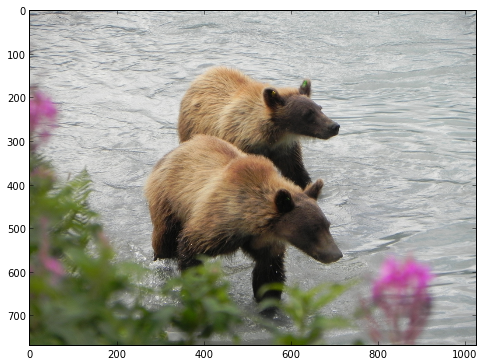

In [204]:
# http://www.flickr.com/photos/32155539@N00/6049931955/sizes/l/in/photostream/
image = 1.0*imread("bearcubs-yosemite-james.jpg")
image /= amax(image)
imshow(image)

Image compression starts off with a linear color space transformation. This transformation separates out an intensity channel (Y) and two color channels (Cb, Cr). The two color channels are zero for grayscale images.



In [205]:
r,g,b = transpose(image,[2,0,1])
y = 0.299*r+0.587*g+0.114*b
cb = -0.168736*r-0.331264*g+0.5*b
cr = +0.5*r-0.418688*g-0.081312*b

Let's look at the three channels.



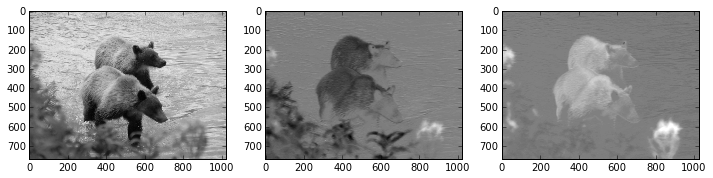

In [206]:
figsize(12,8); gray()
subplot(131); imshow(y)
subplot(132); imshow(cb,vmin=-.2,vmax=.2)
subplot(133); imshow(cr,vmin=-.2,vmax=.2)

In [231]:
# color space conversion functions
def rgb2ycbcr(rgb):
    rgb = rgb/amax(rgb)
    r,g,b = transpose(rgb,[2,0,1])
    y = 0.299*r+0.587*g+0.114*b
    cb = -0.168736*r-0.331264*g+0.5*b
    cr = +0.5*r-0.418688*g-0.081312*b
    return (y,cb,cr)

def ycbcr2rgb(ycbcr):
    y,cb,cr = ycbcr
    r = y + 1.402*cr
    g = y - 0.34414*cb - 0.71414*cr
    b = y + 1.772*cb
    rgb = transpose(array((r,g,b),'f'),[1,2,0])
    return clip(rgb,0,1.0)

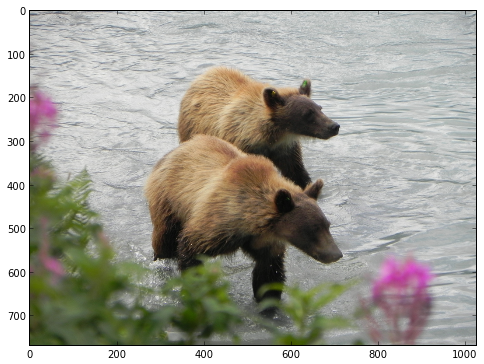

In [232]:
# testing the color space conversion functions
Y,Cb,Cr = rgb2ycbcr(image)
rgb = ycbcr2rgb((Y,Cb,Cr))
imshow(rgb)

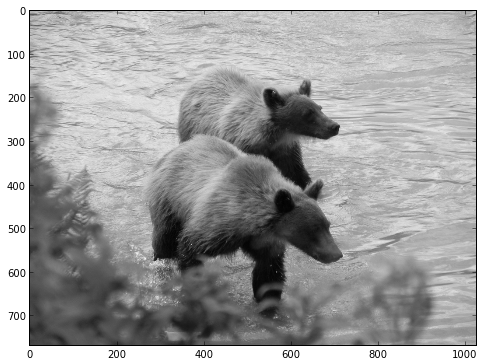

In [233]:
# intensity channel
imshow(Y)

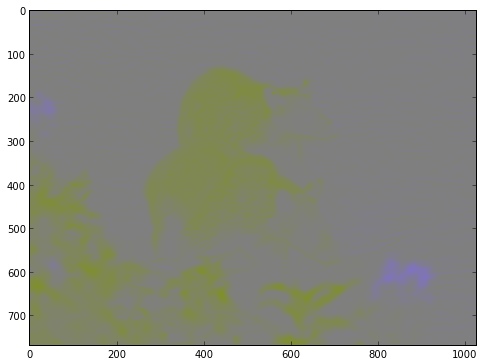

In [234]:
# the Cb channel, keeping Y and Cr constant
imshow(ycbcr2rgb((0.5*ones(Y.shape),Cb,zeros(Cr.shape))))

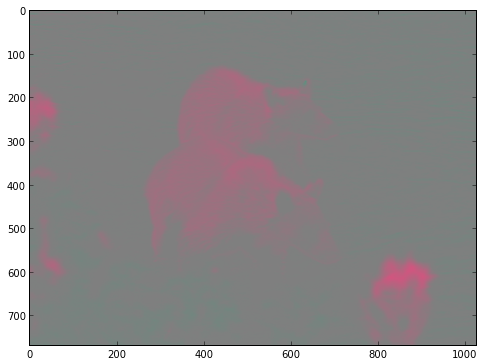

In [235]:
# the Cr channel, keeping Y and Cb constant
imshow(ycbcr2rgb((0.5*ones(Y.shape),zeros(Cb.shape),Cr)))

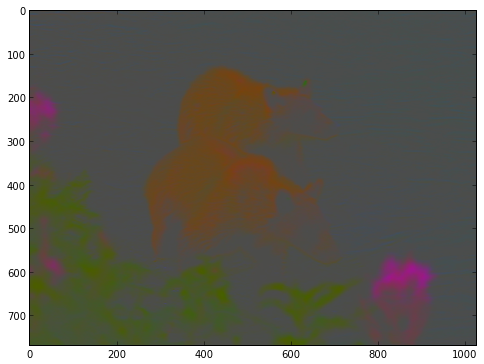

In [274]:
# color information only
imshow(ycbcr2rgb((0.3*ones(Y.shape),Cb,Cr)))

# Downsampling the Color Channels

(intensity channel resolution)

Downsampling or smoothing the intensity channel results in a blurry picture.



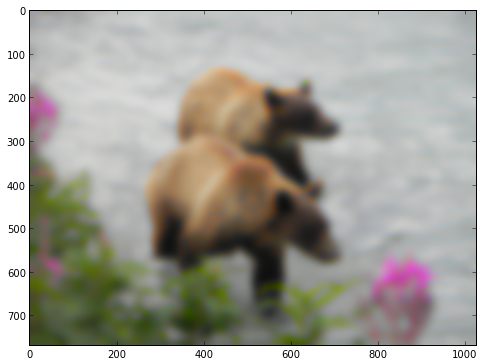

In [267]:
gf = filters.gaussian_filter
yblur = ycbcr2rgb((gf(Y,10.0),Cb,Cr))
imshow(yblur)

-0.198481819608 0.148585788235


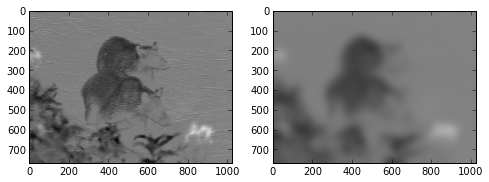

In [239]:
# blurring the color channel
print amin(Cb),amax(Cb)
subplot(121); imshow(Cb,vmin=-0.2,vmax=0.2)
subplot(122); imshow(gf(Cb,20.0),vmin=-0.2,vmax=0.2)

(blurring the color channel)

Even strong blur in the color channel is hardly noticeable.



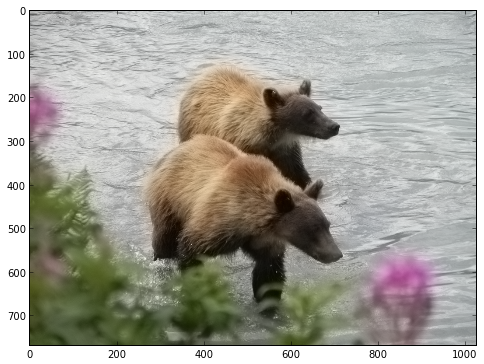

In [268]:
colorblur = ycbcr2rgb((Y,gf(Cb,20.0),gf(Cr,20.0)))
imshow(colorblur)

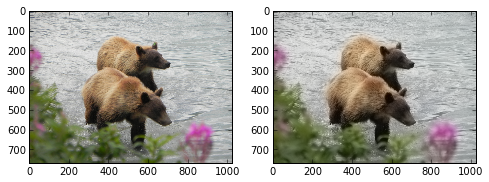

In [275]:
# original vs color blur
subplot(121); imshow(image)
subplot(122); imshow(colorblur)

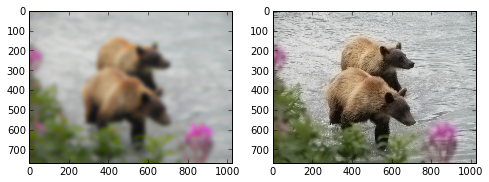

In [276]:
# intensity blur vs color blur
subplot(121); imshow(yblur)
subplot(122); imshow(colorblur)

(summary)

General Observations:

- spatial detail is present primarily in the intensity channel
- blurring the color channels is hardly noticeable

JPEG Compression:

- the Y channel is coded at full resolution
- the Cb and Cr channels are coded at half resolution (1/4 pixels)
- this alone cuts the size of the image in half, even without further compression

# Discrete Cosine Transform

(DFT and DCT)

We looked at length at the Discrete Fourier Transform (DFT). Remember:

- boundary conditions are _periodic_
- periodic sines and cosines form an orthonormal basis
- the DFT decomposes a signal into sines and cosines
- real or complex inputs result in complex transforms
- convolutions turn into multiplications

It turns out that there is also a basis that can be written purely in terms of cosines.
The resulting transform is the Discrete Cosine Transform (DCT):

$$ X_k =
 \sum_{n=0}^{N-1} x_n \cos \left[\frac{\pi}{N} \left(n+\frac{1}{2}\right) k \right] \quad \quad k = 0, \dots, N-1 $$

(Properties of the DCT)

- boundary conditions are _reflective_
- the DCT decomposes a signal purely into cosines
- real inputs result in real outputs
- convolutions turn into linear time arithmetic (not just multiplication)

Reflective boundary conditions and real-to-real make it a very good transform for image compression.

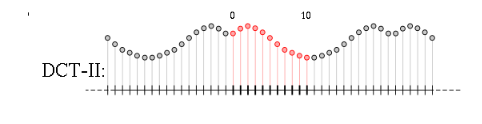

In [241]:
# reflective boundary conditions
axis("off"); imshow(imread("Figures/dct-boundary.png"))

(basis functions)

We can look at the basis functions of the DCT by inverse transforming shifted impulses.



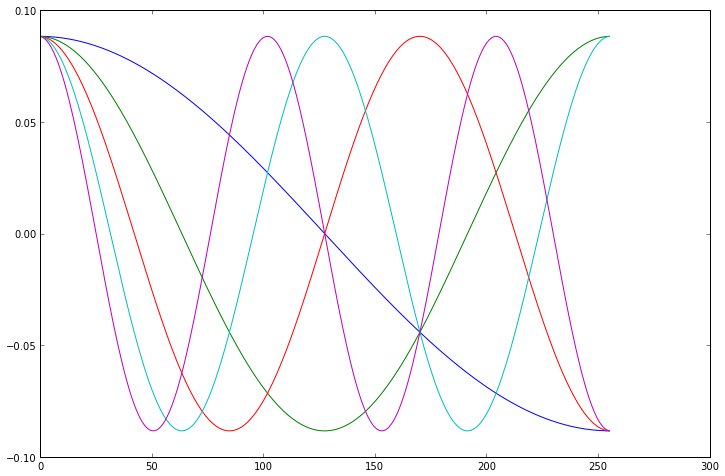

In [216]:
for i in range(1,6):
    transformed = zeros(256)
    transformed[i] = 1.0
    signal = cv2.idct(transformed)
    plot(signal)

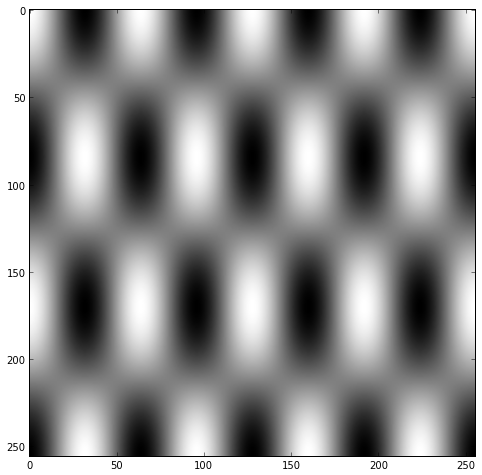

In [242]:
# 2D inverse DCT of a shifted impulse
transformed = zeros((256,256))
transformed[3,8] = 1.0
signal = cv2.idct(transformed)
imshow(signal)

# Visualizing the DCT

The "bears" image above has mostly smooth regions; let's pick an image with some edges for visualizing the results.



(480, 640)


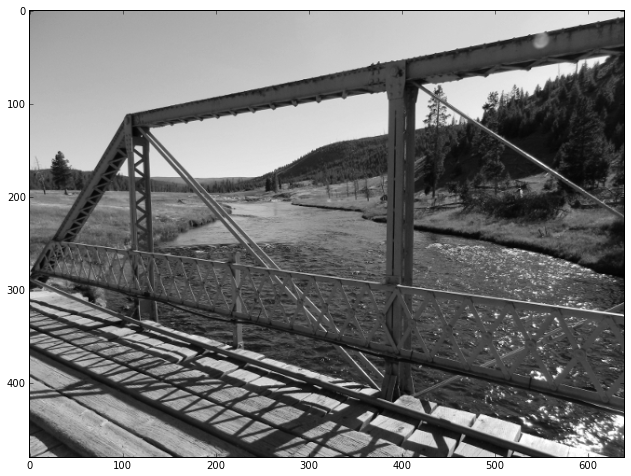

In [219]:
bridge = mean(imread("bridge.jpg"),axis=2)
bridge /= amax(bridge)
print bridge.shape
imshow(bridge)

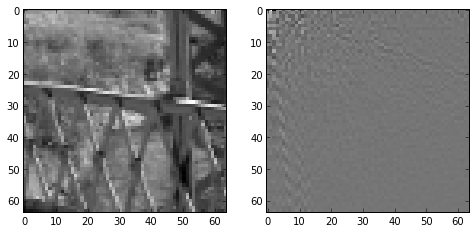

In [243]:
# a patch and its DCT
patch = bridge[230:294,64:128].copy()
patch -= mean(patch)
dct = cv2.dct(patch)
subplot(121); imshow(patch,interpolation='nearest')
subplot(122); imshow(dct,interpolation='nearest')

# Sparse Coefficients

Note that the coefficients are _sparse_: most coefficients are nearly zero.

We can set the near zero coefficients to zero without an appreciable loss in qualitiy.

In [245]:

from scipy import stats
threshold = stats.scoreatpercentile(abs(dct.ravel()),50)
threshold

0.027783365248010505

4096 2048


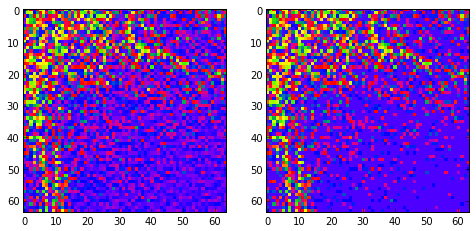

In [246]:
# removing 50 percent of the coefficients
threshold = stats.scoreatpercentile(abs(dct.ravel()),50)
thresholded = where(abs(dct)<threshold,0.0,dct)
print sum(dct!=0),sum(thresholded!=0)
subplot(121); imshow(dct,interpolation='nearest',cmap=cm.prism)
subplot(122); imshow(thresholded,interpolation='nearest',cmap=cm.prism)

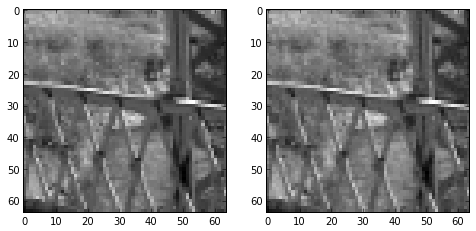

In [247]:
# original vs sparse coefficients
reverse = cv2.idct(dct)
reverse2 = cv2.idct(thresholded)
subplot(121); imshow(reverse,interpolation='nearest')
subplot(122); imshow(reverse2,interpolation='nearest')

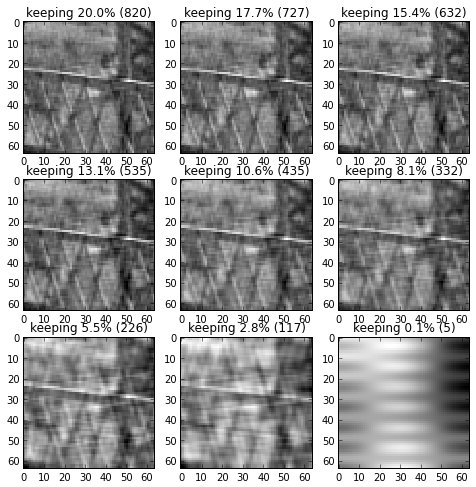

In [249]:
# visualizing quality with sparse coefficients
figsize(8,8)
for i,perc in enumerate(exp(linspace(log(80),log(99.9),9))):
    threshold = stats.scoreatpercentile(abs(dct.ravel()),perc)
    thresholded = where(abs(dct)<threshold,0.0,dct)
    subplot(3,3,i+1)
    imshow(cv2.idct(thresholded),interpolation='nearest')
    title("keeping %.1f%% (%d)"%(100-perc,thresholded.size-sum(thresholded==0.0)))

# Quantization of Coefficients

Real numbers don't compress well, so we need to convert the floating point coefficients to integers.

A simple way of doing this is to divide by a quantization coefficient and then round.



In [225]:
q = 0.05
qdct = array(floor((dct+q/2)/q),'i')
print qdct[:8,:8]

[[  0  38 -32   6   8 -10   3   6]
 [ 12  17  -3   6  -8   2  -3   1]
 [ 14  13   5   8  -2  -6   5  -6]
 [ 13   4   5  -9   1  -4   8   8]
 [  0  -3  -2  -8   3   3  -6  -1]
 [ 12   7   8   3   1  -4   3  -4]
 [ -2  -5  -2  -5  -2   0   3  -1]
 [  2  14  12  -4   5   0  -1  -4]]


In [250]:

figsize(8,8)

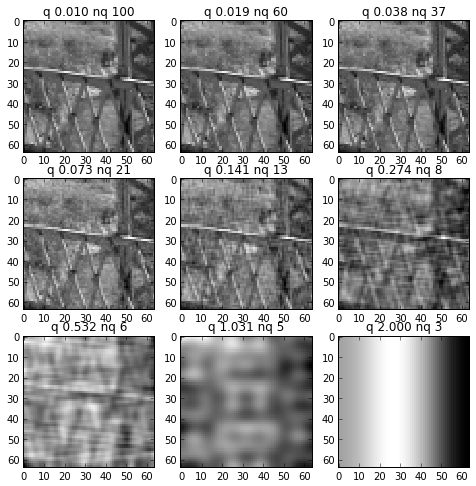

In [251]:
# evaluating different quantization levels
for i,q in enumerate(exp(linspace(log(0.01),log(2.0),9))):
    qdct = array(floor((dct+q/2)/q),'i')
    nq = len(unique(qdct.ravel()))
    rdct = qdct*q
    subplot(3,3,i+1)
    imshow(cv2.idct(rdct),interpolation='nearest')
    title("q %.3f nq %d"%(q,nq))

# DCT Coefficient Statistics

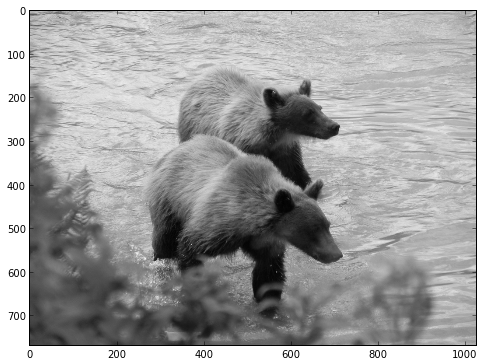

In [253]:
# test image
h,w = Y.shape
imshow(Y)

In [260]:
# computing DCTs for all the patches
dcts = []
for y in range(0,h,8):
    for x in range(0,w,8):
        patch = Y[y:y+8,x:x+8]
        dct = cv2.dct(patch)
        dcts.append(dct)

(visualizing the patches)

Let's look at the DCTs. Notice how they are all very similar to each other.



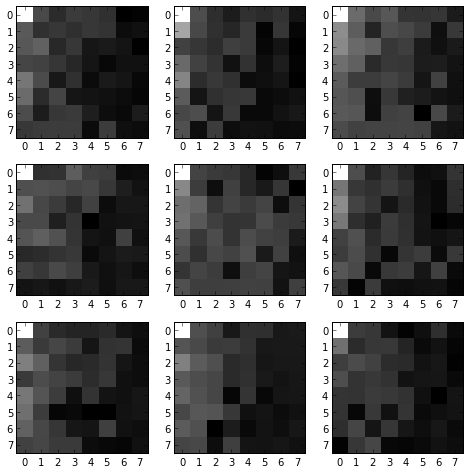

In [263]:
# visualizing the patches
for i in range(0,9):
    subplot(3,3,i+1)
    imshow(abs(dcts[i*4])**.25,interpolation='nearest')

(coefficient variances)

We can see that the variances vary quite consistently, getting smaller the further we get away from the top left corner.



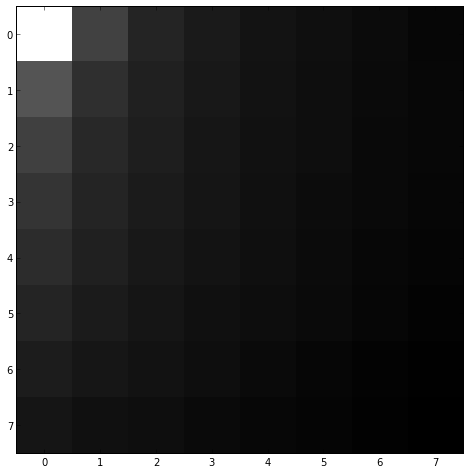

In [264]:
dcts = array(dcts)
vs = var(dcts,axis=0)
imshow(vs**.25,interpolation='nearest')

(standard quantization matrices)

Based on such regularities, JPEG defines standard quantization matrices; each coefficient is divided by the corresponding quantization value, then converted to an integer (these quantization matrices are 255 times as large as in our example above).



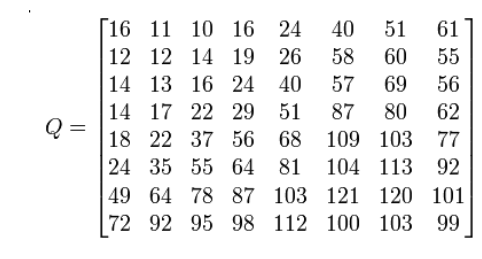

In [265]:
axis("off"); imshow(imread("Figures/jpeg-quant.png"))